In [188]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import skew

from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [189]:
# import train data
batch1 = pd.read_csv('Data/train/Train_Batch_1.csv')
batch2 = pd.read_csv('Data/train/Train_Batch_2.csv')
batch3 = pd.read_csv('Data/train/Train_Batch_3.csv')

# import test data
test = pd.read_csv('Data/test.csv')

Train dataset is composed of numerous files, which could result in minor variations in certain column names or even the internal structure of the data.

So, let's see how can deal with this problem.

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'> Data Understanding </span></b> </div>

In [190]:
print(batch1.shape)
print(batch2.shape)
print(batch3.shape)
print(test.shape)

(19440, 17)
(12956, 18)
(6466, 19)
(19942, 18)


**train data batchs have unsame shapes. We will solve it**

In [191]:
print(batch1.columns)
print('----------------')
print(batch2.columns)
print('----------------')
print(batch3.columns)

Index(['Unnamed: 0', 'Person Description', 'Place Code', 'Customer Order',
       'Additional Features in market', 'Promotion Name', 'Store Kind',
       'Store Sales', 'Store Cost', 'Product Weights Data in (KG)',
       'Is Recyclable?', 'Min. Yearly Income', 'Store Area', 'Grocery Area',
       'Frozen Area', 'Meat Area', 'Cost'],
      dtype='object')
----------------
Index(['Unnamed: 0', 'Person Description', 'Place Code', 'Customer Order',
       'Additional Features in market', 'Promotion Name', 'Store Kind',
       'Store Sales', 'Store Cost', 'Gross Weight', 'Net Weight',
       'Is Recyclable?', 'Min. Person Yearly Income', 'Store Area',
       'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost'],
      dtype='object')
----------------
Index(['Unnamed: 0', 'Person%20Description', 'Place%20Code',
       'Customer%20Order', 'Additional%20Features%20in%20market',
       'Promotion%20Name', 'Store%20Kind', 'Store%20Sales', 'Store%20Cost',
       'Gross%20Weight', 'Net%20Weight', '

**And these columns have differant names. Let's handle that..**

In [192]:
batch1_na = (batch1.isna().sum() / len(batch1)) 
batch1_na = batch1_na.drop(batch1_na[batch1_na == 0].index).sort_values(ascending=False)
batch1_na_data = pd.DataFrame({'mean of nulls' :batch1_na, "num of nulls" : batch1[batch1_na.index].isna().sum()})
batch1_na_data

,mean of nulls,num of nulls
Additional Features in market,0.221193,4300
Promotion Name,0.149691,2910
Store Kind,0.149691,2910
Grocery Area,0.101852,1980
Store Area,0.100669,1957
Meat Area,0.100206,1948
Frozen Area,0.099486,1934
Cost,0.001235,24
Min. Yearly Income,0.000154,3


In [193]:
batch2_na = (batch2.isna().sum() / len(batch2)) 
batch2_na = batch2_na.drop(batch2_na[batch2_na == 0].index).sort_values(ascending=False)
batch2_na_data = pd.DataFrame({'mean of nulls' :batch2_na, "num of nulls" : batch2[batch2_na.index].isna().sum()})
batch2_na_data

,mean of nulls,num of nulls
Gross Weight,0.149892,1942
Net Weight,0.149583,1938
Frozen Area,0.100262,1299
Grocery Area,0.100185,1298
Store Area,0.099799,1293
Promotion Name,0.099645,1291
Store Kind,0.098256,1273
Meat Area,0.097870,1268
Min. Person Yearly Income,0.000309,4
Cost,0.000232,3


In [194]:
batch3_na = (batch3.isna().sum() / len(batch3)) 
batch3_na = batch3_na.drop(batch3_na[batch3_na == 0].index).sort_values(ascending=False)
batch3_na_data = pd.DataFrame({'mean of nulls' :batch3_na, "num of nulls" : batch3[batch3_na.index].isna().sum()})
batch3_na_data

,mean of nulls,num of nulls
Promotion%20Name,0.251624,1627
Store%20Kind,0.251469,1626
Gross%20Weight,0.150789,975
Net%20Weight,0.147696,955
Meat%20Area,0.051500,333
Grocery%20Area,0.050727,328
Frozen%20Area,0.049335,319
Store%20Area,0.048716,315
Store%20Sales,0.002165,14
Store%20Cost,0.001083,7


**There are alot of missing data in each batch. We also will fix it**

We will create functions and apply these functions on all batchs and test set.
The functions will unify the names of the columns in each data and correct the data of each column. 

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'> Feature Engineering  and Data Cleaning </span></b> </div>

In [195]:
batch1.head(3)

,Unnamed: 0,Person Description,Place Code,Customer Order,Additional Features in market,Promotion Name,Store Kind,Store Sales,Store Cost,Product Weights Data in (KG),Is Recyclable?,Min. Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost
0,mc_ID_0,"Single Female with four children, education: b...",H11go_ZA,"Cleaning Supplies from Household department, O...","['Video Store', 'Florist', 'Ready Food', 'Coff...",Dimes Off,Deluxe,8.76 Millions,4.2924 Millions,"{'Gross Weight': 28.1997, 'Net Weight': 26.600...",recyclable,10K+,2842.23,2037.64,481.98,323,602.7575
1,mc_ID_1,"Single Female with three children, education: ...",S04ne_WA,"Snack Foods from Snack Foods department, Order...",NaN,Budget Bargains,Supermarket,6.36 Millions,1.9716 Millions,"{'Gross Weight': 16.571, 'Net Weight': 14.972,...",non recyclable,50K+,2814.95,2049.72,457.36,NaN,708.6650
2,mc_ID_2,"Married Male with two children, education: hig...",L05es_CA,"Magazines from Periodicals department, Ordered...",['Florist'],Shelf Emptiers,Supermarket,10.86 Millions,4.4526 Millions,"{'Gross Weight': 28.6358, 'Net Weight': 27.182...",recyclable,30K+,2192.32,1322.21,523.32,348.85,564.2647


As you can see. This very uncleaned data with very trouble internal structure.
let's clean it.

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Person Description column </mark>**
<br>

We will extract information like: `Marital Status`, `Gender`, `Num Children` and `Education`.
we will put each in seperated column and drop original column.

In [196]:
batch1['Person Description'].value_counts()[:5]

Married Female with four children, education: bachelors degree working as professional         270
Single Male with one child, education: bachelors degree working as professional                253
Married Female with four children, education: partial high school working as skilled manual    245
Married Male with three children, education: bachelors degree working as professional          237
Single Male with three children, education: bachelors degree working as professional           217
Name: Person Description, dtype: int64

In [197]:
def clean_Person_Description_column(df, column):
    
    # Split the "Person Description" column based on delimiters
    df["Description"] = df[column].str.split(",", expand=True)[[0]]

    # Extracting
    df[["Marital Status", "Gender", "Num Children"]] = df["Description"].str.split(" ", expand=True)[[0, 1, 3]]
                                       
    # Clean up whitespace
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Drop the original "Person Description" column
    df.drop(columns=[column, "Description"], inplace=True)
    
    return df

In [198]:
# apply function on dataframes

batch1= clean_Person_Description_column(batch1, 'Person Description')
batch2= clean_Person_Description_column(batch2, 'Person Description')
batch3= clean_Person_Description_column(batch3, 'Person%20Description')

#---------------------------------------------
test= clean_Person_Description_column(test, 'Person Description')

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)">Place Code column </mark>**
<br>

In [199]:
batch1['Place Code'].head()

0    H11go_ZA
1    S04ne_WA
2    L05es_CA
3    S03le_WA
4    M10da_YU
Name: Place Code, dtype: object

Code for each place which consists of 2 city codes parts separated by "_".

We will split each value at  "_"  to extract ISO2 code for the place.

In [200]:
batch3.rename(columns={"Place%20Code": 'Place Code'}, inplace=True)

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)">Customer Order column  </mark>**
<br>

In [201]:
batch1["Customer Order"].value_counts()[:5]

Snack Foods from Snack Foods department, Ordered Brand : Fast           468
Snack Foods from Snack Foods department, Ordered Brand : Nationeel      465
Snack Foods from Snack Foods department, Ordered Brand : Horatio        444
Snack Foods from Snack Foods department, Ordered Brand : Fort West      443
Snack Foods from Snack Foods department, Ordered Brand : Best Choice    412
Name: Customer Order, dtype: int64

We will extract `customer order` information not `department` of order and `Ordered Brand`.
I find this will be useful.

In [202]:
def clean_Customer_Order_column(df, column):
    
    # Split the "Customer Order " column 
    df[["Customer order"]] = df[column].str.split(" from | department", expand=True)[[0]]
    
    df.drop(columns=column, inplace= True)
    return df


In [203]:
batch1= clean_Customer_Order_column(batch1, 'Customer Order')
batch2= clean_Customer_Order_column(batch2, 'Customer Order')
batch3= clean_Customer_Order_column(batch3, 'Customer%20Order')

#-------------------------------------
test= clean_Customer_Order_column(test, 'Customer Order')

In [204]:
batch1.head()

,Unnamed: 0,Place Code,Additional Features in market,Promotion Name,Store Kind,Store Sales,Store Cost,Product Weights Data in (KG),Is Recyclable?,Min. Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,Marital Status,Gender,Num Children,Customer order
0,mc_ID_0,H11go_ZA,"['Video Store', 'Florist', 'Ready Food', 'Coff...",Dimes Off,Deluxe,8.76 Millions,4.2924 Millions,"{'Gross Weight': 28.1997, 'Net Weight': 26.600...",recyclable,10K+,2842.23,2037.64,481.98,323,602.7575,Single,Female,four,Cleaning Supplies
1,mc_ID_1,S04ne_WA,NaN,Budget Bargains,Supermarket,6.36 Millions,1.9716 Millions,"{'Gross Weight': 16.571, 'Net Weight': 14.972,...",non recyclable,50K+,2814.95,2049.72,457.36,NaN,708.6650,Single,Female,three,Snack Foods
2,mc_ID_2,L05es_CA,['Florist'],Shelf Emptiers,Supermarket,10.86 Millions,4.4526 Millions,"{'Gross Weight': 28.6358, 'Net Weight': 27.182...",recyclable,30K+,2192.32,1322.21,523.32,348.85,564.2647,Married,Male,two,Magazines
3,mc_ID_3,S03le_WA,['Coffee Bar'],Savings Galore,NaN,1.98 Millions,0.6732 Millions,"{'Gross Weight': 14.2161, 'Net Weight': 11.294...",recyclable,30K+,1974.73,NaN,440.92,293.95,724.5119,Single,Female,three,Dairy
4,mc_ID_4,M10da_YU,"['Bar For Salad', 'Ready Food', 'Coffee Bar', ...",Sale Winners,Deluxe,11.56 Millions,4.9708 Millions,"{'Gross Weight': 12.6172, 'Net Weight': 9.71, ...",non recyclable,50K+,2862.3,1872.19,593.93,395.95,519.7574,Married,Female,five,Vegetables


### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Additional Features in market column  </mark>**
<br>

In [205]:
batch1["Additional Features in market"].value_counts()[:8]

['Coffee Bar']                                              2230
['Florist']                                                 1322
['Ready Food', 'Bar For Salad']                             1037
['Bar For Salad', 'Ready Food']                              933
['Florist', 'Bar For Salad', 'Coffee Bar', 'Ready Food']     133
['Florist', 'Ready Food', 'Coffee Bar', 'Bar For Salad']     125
['Coffee Bar', 'Bar For Salad', 'Ready Food', 'Florist']     124
['Bar For Salad', 'Coffee Bar', 'Florist', 'Ready Food']     121
Name: Additional Features in market, dtype: int64

This column contains lists not single value. That is very unuseless. becouse we should focus on extacting information from that type of columns, we will calcoulate the lenght of this lists expresses the number of features in market. 

We will create a new column `Additional Features count` and drop old column `Additional Features in market`.

In [206]:
def clean_Additional_Features_column(df, column):
    
   # Create columns for each unique value and fill with 1 if the value exists, 0 otherwise
    
    df[column] = df[column].apply(lambda x: [] if pd.isna(x) else x)
    unique_values = ["Coffee Bar", "Florist", "Ready Food", "Bar For Salad", 'Video Store']
    for value in unique_values:
        df[value] = df[column].apply(lambda x: 1 if value in x else 0)

    
    df.drop(columns=column, inplace=True)
    
    return df

In [207]:
batch1= clean_Additional_Features_column(batch1, 'Additional Features in market')
batch2= clean_Additional_Features_column(batch2, 'Additional Features in market')
batch3= clean_Additional_Features_column(batch3, 'Additional%20Features%20in%20market')

#------------------------------------
test= clean_Additional_Features_column(test, 'Additional Features in market')

In [208]:
batch1[["Coffee Bar", "Florist", "Ready Food", "Bar For Salad", 'Video Store']].head()

,Coffee Bar,Florist,Ready Food,Bar For Salad,Video Store
0,1,1,1,1,1
1,0,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,1,1,1,1


### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)">Store Sales and Store cost columns  </mark>**
<br>

In [209]:
batch1[['Store Sales', 'Store Cost']].head()

,Store Sales,Store Cost
0,8.76 Millions,4.2924 Millions
1,6.36 Millions,1.9716 Millions
2,10.86 Millions,4.4526 Millions
3,1.98 Millions,0.6732 Millions
4,11.56 Millions,4.9708 Millions


The two columns in string format that each value in this columns contains a string value beside the number. So we will remove the string and convert the columns in float type.

we will rename the columns into `Store Sales (M)` and `Store Cost (M)` and create `Sales Cost ratio` column.

In [210]:
def clean_StoreSales_and_Storecost_columns(df, column1, column2):
    
    df[['Store Sales (M)', 'Store Cost (M)']] = df[[column1, column2]].applymap(lambda x: str(x).split()[0])
    df[['Store Sales (M)', 'Store Cost (M)']] = df[['Store Sales (M)', 'Store Cost (M)']].astype(float)
    #df['Sales Cost ratio']= df['Store Cost (M)'] / df['Store Sales (M)']
    
    df.drop(columns=[column1, column2], inplace=True)
    return df


In [211]:
batch1= clean_StoreSales_and_Storecost_columns(batch1, 'Store Sales', 'Store Cost')
batch2= clean_StoreSales_and_Storecost_columns(batch2, 'Store Sales', 'Store Cost')
batch3= clean_StoreSales_and_Storecost_columns(batch3, 'Store%20Sales', 'Store%20Cost')

#--------------------------------------------
test= clean_StoreSales_and_Storecost_columns(test, 'Store Sales', 'Store Cost')

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Product Weights Data in (KG) column </mark>**
<br>

In [212]:
batch1["Product Weights Data in (KG)"].value_counts()[:5]

{'Gross Weight': 27.0368, 'Net Weight': 24.1296, 'Package Weight': 2.9072}    161
{'Gross Weight': 28.9265, 'Net Weight': 25.874, 'Package Weight': 3.0525}     131
{'Gross Weight': 19.7689, 'Net Weight': 16.8617, 'Package Weight': 2.9072}    126
{'Gross Weight': 21.3678, 'Net Weight': 18.3153, 'Package Weight': 3.0525}    121
{'Gross Weight': 14.972, 'Net Weight': 12.0648, 'Package Weight': 2.9072}     117
Name: Product Weights Data in (KG), dtype: int64

This column contain a dict values each dict contain 3 values. We will seperate each value in dict into a single column.

Three values are:
* Gross Weight
* Net Weight
* Package Weight

**`Note`**: 

1- batch2 dataframe doesn't have this column but have just a Gross Weight and Net Weight columns.

2- batch3 dataframe has this column addition to Gross Weight and Net Weight columns.

3- Gross Weight **=** Net Weight **+** Package Weight.

In [213]:
import ast

def clean_Product_Weights_column(df, column):
    
    df[['Gross Weight', 'Net Weight', 'Package Weight']] = df[column].apply(
        lambda x: pd.Series(ast.literal_eval(x).values()))
    
    df.drop(columns=column, inplace=True)
    
    return df


In [214]:
batch1= clean_Product_Weights_column(batch1, 'Product Weights Data in (KG)')
batch3= clean_Product_Weights_column(batch3, 'Weights%20Data')

check about nulls in test set

In [215]:
test[['Gross Weight', 'Net Weight', 'Package Weight']].isna().sum()

Gross Weight       983
Net Weight        1018
Package Weight       0
dtype: int64

In [216]:
test['Gross Weight'].fillna(test['Net Weight']+test['Package Weight'], inplace=True)
test['Gross Weight'].fillna(test['Package Weight']+(test['Net Weight'].mean()), inplace=True)
test['Net Weight'].fillna(test['Gross Weight']-test['Package Weight'].mean(), inplace=True)

In [217]:
test[['Package Weight', 'Gross Weight', 'Net Weight']].isna().sum()

Package Weight    0
Gross Weight      0
Net Weight        0
dtype: int64

check about nulls in batch2

In [218]:
batch2[['Gross Weight', 'Net Weight']].isna().sum()

Gross Weight    1942
Net Weight      1938
dtype: int64

**Fill nulls in `Gross Weight` and `Net Weight` column in batch2 and create `Package Weight` column**

In [219]:
value= round((batch2['Gross Weight']/batch2['Net Weight']).mean(),2)
batch2['Gross Weight'].fillna(batch2['Net Weight']*value, inplace=True)
batch2['Gross Weight'].fillna(batch2['Gross Weight'].mean(), inplace=True)

batch2['Net Weight'].fillna(batch2['Gross Weight']*(value**-1), inplace=True)

In [220]:
batch2['Package Weight']= batch2['Gross Weight']-batch2['Net Weight']

In [221]:
batch2[['Package Weight', 'Gross Weight',  'Net Weight']].isna().sum()

Package Weight    0
Gross Weight      0
Net Weight        0
dtype: int64

In [222]:
batch3.drop(columns= ['Gross%20Weight', 'Net%20Weight'], inplace=True)   

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Is Recyclable? column  </mark>**
<br>

In [223]:
batch1["Is Recyclable?"].unique()

array(['recyclable', 'non recyclable'], dtype=object)

In [224]:
batch2["Is Recyclable?"].unique()

array(['yes', 'no'], dtype=object)

In [225]:
batch3["Is%20Recyclable?"].unique()

array(['yes', 'no', nan], dtype=object)

If the item in market is Recyclable or no. But where is the problem here? 

Unique values in batch1 are `recyclable` and `non Recyclable` But in batch2 and batch3 are `yes` and `no`

let's handle that.

In [226]:
def clean_Is_Recyclable_column(df, column):
    
    df[column].fillna(df[column].mode()[0], inplace=True)
    
    if list(df[column].unique()) == ['yes', 'no']:
        df['Is Recyclable']=df[column].map({'yes':1, 'no':0})
    
    else:
        df['Is Recyclable']=df[column].map({'recyclable':1, 'non recyclable':0})
        
        
    df.drop(columns=column, inplace=True)
    return df


In [227]:
batch1= clean_Is_Recyclable_column(batch1, "Is Recyclable?")
batch2= clean_Is_Recyclable_column(batch2, "Is Recyclable?")
batch3= clean_Is_Recyclable_column(batch3, "Is%20Recyclable?")

#---------------------------------------
test= clean_Is_Recyclable_column(test, "Is Recyclable?")

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Yearly Income column  </mark>**
<br>

In [228]:
def rename_to_YearlyIncome(df, column):
    df.rename(columns={column: 'Yearly Income'}, inplace=True)
    return df

In [229]:
batch1= rename_to_YearlyIncome(batch1, 'Min. Yearly Income')
batch2= rename_to_YearlyIncome(batch2, 'Min. Person Yearly Income')
batch3= rename_to_YearlyIncome(batch3, 'Yearly%20Income')

### **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Area columns  </mark>**
<br>

In [230]:
batch1[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].head()

,Meat Area,Grocery Area,Frozen Area,Store Area
0,323,2037.64,481.98,2842.23
1,NaN,2049.72,457.36,2814.95
2,348.85,1322.21,523.32,2192.32
3,293.95,NaN,440.92,1974.73
4,395.95,1872.19,593.93,2862.3


In [231]:
batch1[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].dtypes

Meat Area        object
Grocery Area     object
Frozen Area     float64
Store Area       object
dtype: object

In [232]:
batch2[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].dtypes

Meat Area       float64
Grocery Area    float64
Frozen Area      object
Store Area      float64
dtype: object

In [233]:
batch3[['Meat%20Area','Grocery%20Area', 'Frozen%20Area', 'Store%20Area']].dtypes

Meat%20Area       float64
Grocery%20Area    float64
Frozen%20Area     float64
Store%20Area      float64
dtype: object

Area columns included `Store Area`, `Meat Area`, `Grocery Area` and `Frozen Area`.

Each dataframe contain some of these columns in object type and some of unacceptable values like 'missing' not `nan`, '542.20' not `542.20` and '754.53.' not `754.53`. 

We should handle this problems frist then convert a column to float type.

**`Note:`**

1- Only batch3 dataframe has all these columns in float type. 

2- `Store Area` column almost equal the sum of `Meat Area`, `Grocery Area` and `Frozen Area`.

In [234]:
def convert_to_float(df, column):
    
    df[column] = df[column].str.replace('"', '')
    df[column] = [np.nan if value in ['missing', ''] else value for value in df[column].values]
    
    # Remove trailing periods
    df[column] = df[column].str.rstrip('.')
    
    df[column] = df[column].astype(float)

    #to_rename_column
    new_column = column.replace('%20', ' ')
    df.rename(columns={column: new_column}, inplace=True)
    
    #fill nulls
    df[column].fillna(df[column].mean())
    
    return df

In [235]:
batch1 = convert_to_float(batch1, 'Meat Area')
batch1 = convert_to_float(batch1, 'Store Area')
batch1 = convert_to_float(batch1, 'Grocery Area')

In [236]:
batch2 = convert_to_float(batch2, 'Frozen Area')

If we check about nulls values in these columns, we will find almost 2000 missing values in each column.

So, itis important to impute these values by suitable technique. Let's See how to impute columns!!

In [237]:
batch1[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].isna().sum()

Meat Area       1948
Grocery Area    1981
Frozen Area     1934
Store Area      1958
dtype: int64

In [238]:
def impute_area_columns(df):
    
    df['Store Area'].fillna(df['Meat Area']+df['Grocery Area']+df['Frozen Area'], inplace=True)
    df['Grocery Area'].fillna(df['Store Area']-(df['Meat Area']+df['Frozen Area']), inplace=True)
    df['Meat Area'].fillna(df['Store Area']-(df['Grocery Area']+df['Frozen Area']), inplace=True)
    df['Frozen Area'].fillna(df['Store Area']-(df['Meat Area']+df['Grocery Area']), inplace=True)
    
    df['Grocery Area'].fillna(df['Grocery Area'].mean(), inplace=True)
    df['Meat Area'].fillna(df['Meat Area'].mean(), inplace=True)
    df['Frozen Area'].fillna(df['Frozen Area'].mean(), inplace=True)
    df['Store Area'].fillna(df['Meat Area']+df['Grocery Area']+df['Frozen Area'], inplace=True)
    return df

In [239]:
batch1=impute_area_columns(batch1)
batch1[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].isna().sum()

Meat Area       0
Grocery Area    0
Frozen Area     0
Store Area      0
dtype: int64

In [240]:
batch2=impute_area_columns(batch2)
batch2[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].isna().sum()

Meat Area       0
Grocery Area    0
Frozen Area     0
Store Area      0
dtype: int64

In [241]:
#to_rename_column
for column in ['Grocery%20Area', 'Store%20Area', 'Frozen%20Area', 'Meat%20Area']:
    new_column = column.replace('%20', ' ')
    batch3.rename(columns={column: new_column}, inplace=True)
    

batch3=impute_area_columns(batch3)
batch3[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].isna().sum()

Meat Area       0
Grocery Area    0
Frozen Area     0
Store Area      0
dtype: int64

In [242]:
test=impute_area_columns(test)
test[['Meat Area','Grocery Area', 'Frozen Area', 'Store Area']].isna().sum()

Meat Area       0
Grocery Area    0
Frozen Area     0
Store Area      0
dtype: int64

In [243]:
batch3.rename(columns={'Promotion%20Name': 'Promotion Name',
                       'Store%20Kind': 'Store Kind'}, inplace=True)

In [244]:
batch1.iloc[:5,3:]

,Store Kind,Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,Marital Status,Gender,Num Children,...,Florist,Ready Food,Bar For Salad,Video Store,Store Sales (M),Store Cost (M),Gross Weight,Net Weight,Package Weight,Is Recyclable
0,Deluxe,10K+,2842.23,2037.64,481.98,323.00,602.7575,Single,Female,four,...,1,1,1,1,8.76,4.2924,28.1997,26.6008,1.5990,1
1,Supermarket,50K+,2814.95,2049.72,457.36,307.87,708.6650,Single,Female,three,...,0,0,0,0,6.36,1.9716,16.5710,14.9720,1.5990,0
2,Supermarket,30K+,2192.32,1322.21,523.32,348.85,564.2647,Married,Male,two,...,1,0,0,0,10.86,4.4526,28.6358,27.1822,1.4536,1
3,NaN,30K+,1974.73,1239.86,440.92,293.95,724.5119,Single,Female,three,...,0,0,0,0,1.98,0.6732,14.2161,11.2944,2.9217,1
4,Deluxe,50K+,2862.30,1872.19,593.93,395.95,519.7574,Married,Female,five,...,1,1,1,1,11.56,4.9708,12.6172,9.7100,2.9072,0


### Now we will concatenate all three dataframes into one.

In [245]:
print(batch1.shape)
print(batch2.shape)
print(batch3.shape)
print(test.shape)

(19440, 25)
(12956, 25)
(6466, 25)
(19942, 24)


In [246]:
train_columns= list(batch1.columns)
batch1= batch1[train_columns]
batch2= batch2[train_columns]
batch3= batch3[train_columns]

In [247]:
train = pd.concat([batch1, batch2, batch3])
train = train.reset_index(drop=True)
train.head()

,Unnamed: 0,Place Code,Promotion Name,Store Kind,Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,...,Florist,Ready Food,Bar For Salad,Video Store,Store Sales (M),Store Cost (M),Gross Weight,Net Weight,Package Weight,Is Recyclable
0,mc_ID_0,H11go_ZA,Dimes Off,Deluxe,10K+,2842.23,2037.64,481.98,323.00,602.7575,...,1,1,1,1,8.76,4.2924,28.1997,26.6008,1.5990,1
1,mc_ID_1,S04ne_WA,Budget Bargains,Supermarket,50K+,2814.95,2049.72,457.36,307.87,708.6650,...,0,0,0,0,6.36,1.9716,16.5710,14.9720,1.5990,0
2,mc_ID_2,L05es_CA,Shelf Emptiers,Supermarket,30K+,2192.32,1322.21,523.32,348.85,564.2647,...,1,0,0,0,10.86,4.4526,28.6358,27.1822,1.4536,1
3,mc_ID_3,S03le_WA,Savings Galore,NaN,30K+,1974.73,1239.86,440.92,293.95,724.5119,...,0,0,0,0,1.98,0.6732,14.2161,11.2944,2.9217,1
4,mc_ID_4,M10da_YU,Sale Winners,Deluxe,50K+,2862.30,1872.19,593.93,395.95,519.7574,...,1,1,1,1,11.56,4.9708,12.6172,9.7100,2.9072,0


In [248]:
train.drop(columns='Unnamed: 0', inplace=True)

In [249]:
train.shape

(38862, 24)

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'>Handle with nulls </span></b> </div>

In [250]:
train_na = (train.isna().sum() / len(train)) 
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
train_na_data = pd.DataFrame({'mean of nulls' :train_na, "num of nulls" : train[train_na.index].isna().sum()})
train_na_data

,mean of nulls,num of nulls
Promotion Name,0.149967,5828
Store Kind,0.149478,5809
Cost,0.000798,31
Store Sales (M),0.000386,15
Yearly Income,0.000206,8
Store Cost (M),0.000180,7
Customer order,0.000051,2


In [251]:
test_na = (test.isna().sum() / len(test)) 
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
test_na_data = pd.DataFrame({'mean of nulls' :test_na, "num of nulls" : test[test_na.index].isna().sum()})
test_na_data

,mean of nulls,num of nulls
Store Kind,0.001404,28
Promotion Name,0.001304,26


**Promotion Name and Store Kind**

We will impute `Promotion Name` based on `Store Kind` and vice versa.

In [252]:
len(train[train['Promotion Name'].isna() & train['Store Kind'].isna()])

1004

There will still be 1004 missing data in both columns.We will impute them with `mode()` method.

In [253]:
train['Store Kind'].value_counts()

Supermarket      14315
Deluxe           12602
Gourmet           3554
Mid-Size          1497
Small Grocery     1085
Name: Store Kind, dtype: int64

In [254]:
train['Promotion Name'].value_counts()[:10]

Save Price               1288
Weekend Discount         1279
Two Day Sale             1258
Price Winners            1157
Super Savers             1086
Save It (Sale)           1074
Super Duper Savers       1066
One Day Sale             1010
Roller Savings (High)     992
Sale : Double Down        970
Name: Promotion Name, dtype: int64

In [255]:
StoreKind_by_Promotion = train.groupby(['Store Kind', 'Promotion Name']).size().reset_index().sort_values(by=0, ascending=False)
max_indices = StoreKind_by_Promotion.groupby('Store Kind')[0].idxmax()
StoreKind_by_Promotion.loc[max_indices].sort_values(by=0,ascending=False)

,Store Kind,Promotion Name,0
171,Supermarket,Weekend Discount,786
13,Deluxe,Lottery Cash Registerion,726
60,Gourmet,Two Day Sale,319
65,Mid-Size,Budget Bargains,98
108,Small Grocery,Price Winners,51


In [256]:
Promotion_by_StoreKind = train.groupby(['Promotion Name', 'Store Kind']).size().reset_index().sort_values(by=0, ascending=False)
max_indices = Promotion_by_StoreKind.groupby('Promotion Name')[0].idxmax()
Promotion_by_StoreKind.loc[max_indices].sort_values(by=0,ascending=False).head()

,Promotion Name,Store Kind,0
169,Weekend Discount,Supermarket,786
55,Lottery Cash Registerion,Deluxe,726
118,Save Price,Deluxe,638
97,Sale : Double Down,Deluxe,556
142,Super Savers,Supermarket,547


In [257]:
for index, row in train.iterrows():
    promotion_name = row['Promotion Name']
    
    if pd.isnull(row['Store Kind']):
        if pd.isnull(promotion_name): train.at[index, 'Store Kind'] = row['Store Kind']
            
        elif promotion_name in ['Weekend Discount', 'Super Savers', 'Save It (Sale)', 'Roller Savings (High)', 'Savings Galore', 'Go For It',
                               'Big Time Discounts', 'Shelf Clearing Days', 'Best Price Savers', 'Price Slashers', 'Full Free', 'Budget Bargains',
                               'Sales Days', 'You Save Days', 'Price Destroyers', 'Two Day Sale', 'Two for One',
                               'Saving Days', 'Wallet Savers', 'Three for One', 'Best Savings', 'Mystery Sale', 'Super Wallet Savers',
                               'Sale Sale Sale', 'Double Your Savings']:
            train.at[index, 'Store Kind'] = 'Supermarket'
        elif promotion_name in ['Lottery Cash Registerion', 'Save Price', 'Sale : Double Down', 'Super Duper Savers', 'Bag Stuffer',
                                 'Price Winners', 'Dimes Off', 'One Day Sale', 'I Cant Believe It Sale', 'Money Savers',
                                 'GLD', 'Tip Top Savings', 'Promo Big', 'Discount Frenzy', 'Sale Winners', 'Dollar Days',
                                 'Big Time Saving', 'Pick Your Savings', 'Price Smashers', 'Green Light Special']:
            train.at[index, 'Store Kind'] = 'Deluxe'
        elif promotion_name in ['Shelf Emptiers', 'Price Cutters', 'Fantastic Discounts']:
            train.at[index, 'Store Kind'] = 'Gourmet'
        elif promotion_name == 'Coupon Spectacular':
            train.at[index, 'Store Kind'] = 'Mid-Size'


In [258]:
promotion_mapping = {
    'Supermarket': 'Weekend Discount',
    'Deluxe': 'Lottery Cash Registerion',
    'Gourmet': 'Two Day Sale',
    'Mid-Size': 'Budget Bargains',
    'Small Grocery': 'Price Winners'
}

train['Promotion Name'] = train.apply(lambda row: promotion_mapping.get(row['Store Kind']) if pd.isnull(row['Promotion Name']) else row['Promotion Name'], axis=1)

In [259]:
train['Promotion Name'].fillna(train['Promotion Name'].mode()[0], inplace= True)
train['Store Kind'].fillna(train['Store Kind'].mode()[0], inplace= True)

In [260]:
test['Promotion Name'].fillna(test['Promotion Name'].mode()[0], inplace= True)
test['Store Kind'].fillna(test['Store Kind'].mode()[0], inplace= True)

**Cost, Store Sales (M), Store Cost (M) and Sales Cost ratio**

In [261]:
columns_to_fill = ['Cost', 'Store Sales (M)', 'Store Cost (M)']
train[columns_to_fill] = train[columns_to_fill].fillna(train[columns_to_fill].mean())

In [262]:
for col in ['Yearly Income', 'Customer order']:
    train[col] = train[col].fillna(train[col].mode()[0])

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'>  Explore data </span></b> </div>

In [263]:
descrete_cols= [col for col in train.columns if train[col].nunique() < 10 and train[col].dtypes != 'O']

# numerical columns
num_cols= [col for col in train.columns if train[col].dtypes != 'O']
num_cols= [col for col in num_cols if col not in descrete_cols]

print(f'number of numerical columns: {len(num_cols)}')
print(f'num_cols: {num_cols}')
print('------------------------')
print(f'number of descrete columns: {len(descrete_cols)}')
print(f'descrete columns: {descrete_cols}')

number of numerical columns: 10
num_cols: ['Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost', 'Store Sales (M)', 'Store Cost (M)', 'Gross Weight', 'Net Weight', 'Package Weight']
------------------------
number of descrete columns: 6
descrete columns: ['Coffee Bar', 'Florist', 'Ready Food', 'Bar For Salad', 'Video Store', 'Is Recyclable']


In [264]:
def two_plots_num_column(df, feature):
    
    print(f"the skewness value of {feature} column = {df[feature].skew():.2f}")
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('histgram')
    sns.histplot(data=df, x=feature, kde=True)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    plt.subplot(1,2,2)
    plt.title('Boxplot')
    sns.boxplot(y=df[feature])

the skewness value of Store Area column = 0.42


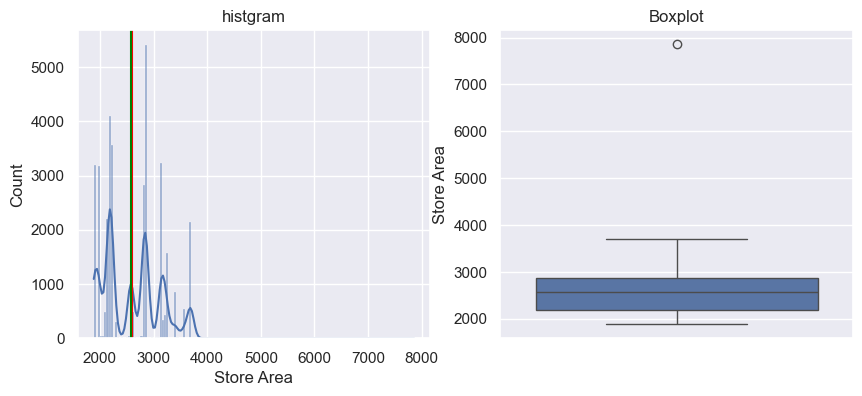

In [265]:
two_plots_num_column(train, 'Store Area')

In [266]:
train.loc[train['Store Area']>4200,'Store Area'] = train['Store Area'].mean()

the skewness value of Grocery Area column = 0.57


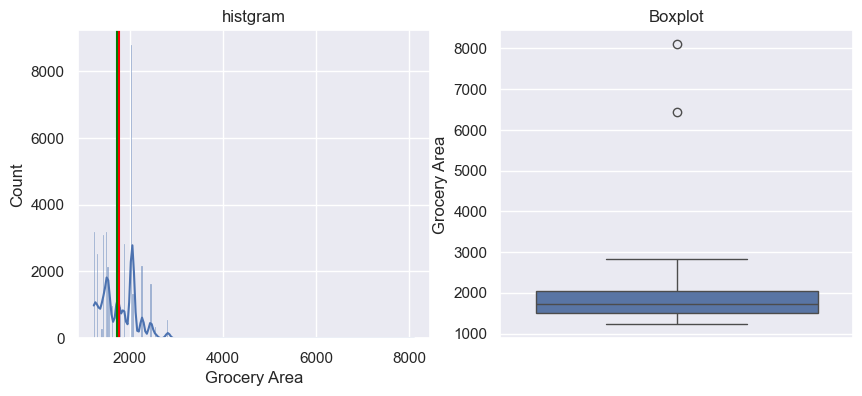

In [267]:
two_plots_num_column(train, 'Grocery Area')

In [268]:
train.loc[train['Grocery Area']>3000,'Grocery Area'] = train['Grocery Area'].mean()

the skewness value of Frozen Area column = 0.58


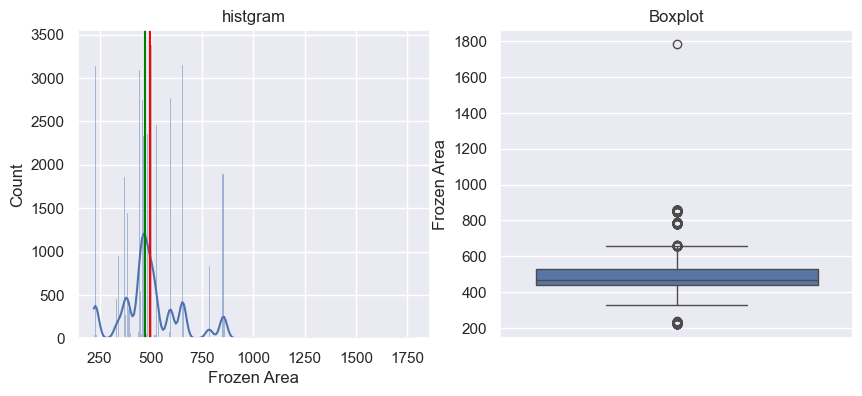

In [269]:
two_plots_num_column(train, 'Frozen Area')

In [270]:
train.loc[train['Frozen Area']>1000,'Frozen Area'] = train['Frozen Area'].mean()

the skewness value of Store Sales (M) column = 0.69


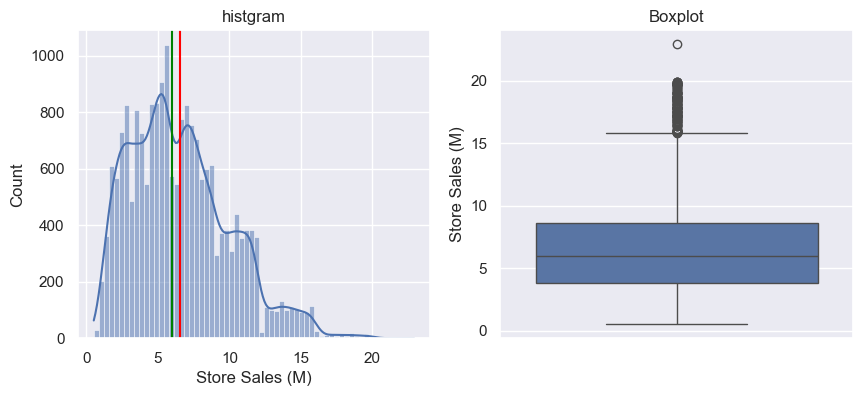

In [271]:
two_plots_num_column(test, 'Store Sales (M)')

In [272]:
test.loc[test['Store Sales (M)']>20,'Store Sales (M)'] = test['Store Sales (M)'].mean()

the skewness value of Store Cost (M) column = 0.83


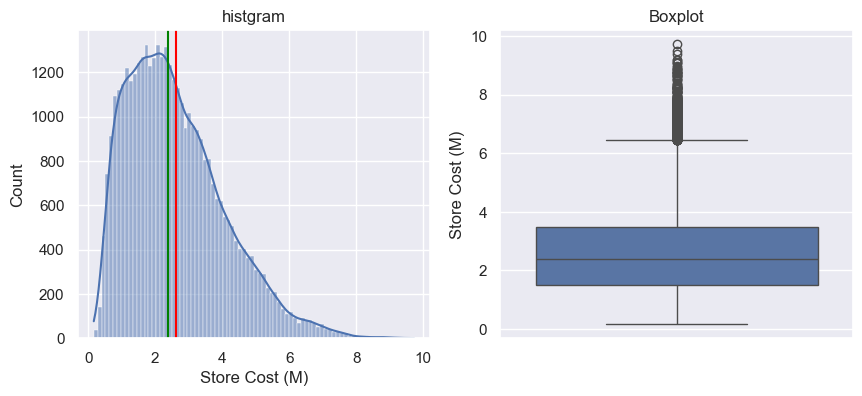

In [273]:
two_plots_num_column(train, 'Store Cost (M)')

In [274]:
test.loc[test['Store Cost (M)']>8,'Store Cost (M)'] = test['Store Cost (M)'].mean()
train.loc[train['Store Cost (M)']>8,'Store Cost (M)'] = train['Store Cost (M)'].mean()

In [275]:
cat_cols = [col for col in train.columns if train[col].dtypes == 'O']

# categorical columns
cat_cols 

['Place Code',
 'Promotion Name',
 'Store Kind',
 'Yearly Income',
 'Marital Status',
 'Gender',
 'Num Children',
 'Customer order']

In [276]:
train.columns

Index(['Place Code', 'Promotion Name', 'Store Kind', 'Yearly Income',
       'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost',
       'Marital Status', 'Gender', 'Num Children', 'Customer order',
       'Coffee Bar', 'Florist', 'Ready Food', 'Bar For Salad', 'Video Store',
       'Store Sales (M)', 'Store Cost (M)', 'Gross Weight', 'Net Weight',
       'Package Weight', 'Is Recyclable'],
      dtype='object')

In [277]:
train_columns = ['Place Code', 'Promotion Name', 'Store Kind', 'Yearly Income',
       'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Marital Status', 'Gender', 'Num Children', 'Customer order', 'Coffee Bar', 'Florist',
       'Ready Food', 'Bar For Salad', 'Video Store', 'Store Sales (M)',
       'Store Cost (M)', 'Gross Weight', 'Net Weight',
       'Package Weight', 'Is Recyclable', 'Cost']

In [278]:
test_columns = ['Unnamed: 0','Place Code', 'Promotion Name', 'Store Kind', 'Yearly Income',
       'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Marital Status', 'Gender', 'Num Children', 'Customer order', 'Coffee Bar', 'Florist',
       'Ready Food', 'Bar For Salad', 'Video Store', 'Store Sales (M)',
       'Store Cost (M)', 'Gross Weight', 'Net Weight',
       'Package Weight', 'Is Recyclable']

In [279]:
train = train[train_columns]
test = test[test_columns]

In [280]:
train.head(3)

,Place Code,Promotion Name,Store Kind,Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Marital Status,Gender,...,Ready Food,Bar For Salad,Video Store,Store Sales (M),Store Cost (M),Gross Weight,Net Weight,Package Weight,Is Recyclable,Cost
0,H11go_ZA,Dimes Off,Deluxe,10K+,2842.23,2037.64,481.98,323.00,Single,Female,...,1,1,1,8.76,4.2924,28.1997,26.6008,1.5990,1,602.7575
1,S04ne_WA,Budget Bargains,Supermarket,50K+,2814.95,2049.72,457.36,307.87,Single,Female,...,0,0,0,6.36,1.9716,16.5710,14.9720,1.5990,0,708.6650
2,L05es_CA,Shelf Emptiers,Supermarket,30K+,2192.32,1322.21,523.32,348.85,Married,Male,...,0,0,0,10.86,4.4526,28.6358,27.1822,1.4536,1,564.2647


In [281]:
test.iloc[:3,3:]

,Store Kind,Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Marital Status,Gender,Num Children,Customer order,...,Florist,Ready Food,Bar For Salad,Video Store,Store Sales (M),Store Cost (M),Gross Weight,Net Weight,Package Weight,Is Recyclable
0,Gourmet,50K+,2201.06,1424.85,465.54,308.73,Single,Male,four,Candy,...,1,1,1,1,11.76,4.7040,31.8337,28.7811,3.0525,1
1,Deluxe,70K+,2577.16,1735.17,505.07,336.59,Married,Female,three,Vegetables,...,1,1,1,1,2.16,0.6696,29.9440,27.0368,2.9072,0
2,Deluxe,130K+,2837.58,2038.11,481.98,321.26,Single,Female,three,Dairy,...,1,1,1,1,1.83,0.8235,29.2172,26.3100,2.9072,0


In [282]:
train.to_csv('cleaned_train.csv', index=False)
test.to_csv('cleaned_test.csv', index=False)

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'>Prepare data for modeling</span></b> </div>

## **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)">Encoding </mark>**
<br>

In [283]:
def label_encoder(dataframe, cols_to_encode):
    labelencoder = LabelEncoder()
    for col in cols_to_encode:
        dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

train = label_encoder(train, cat_cols)
test = label_encoder(test, cat_cols)

## **<mark style="color:#404040;border-radius:20px;opacity:1.5;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"> Check about Multicollinearity  </mark>**
<br>

It means that the independant variables should not have any correlation between each other

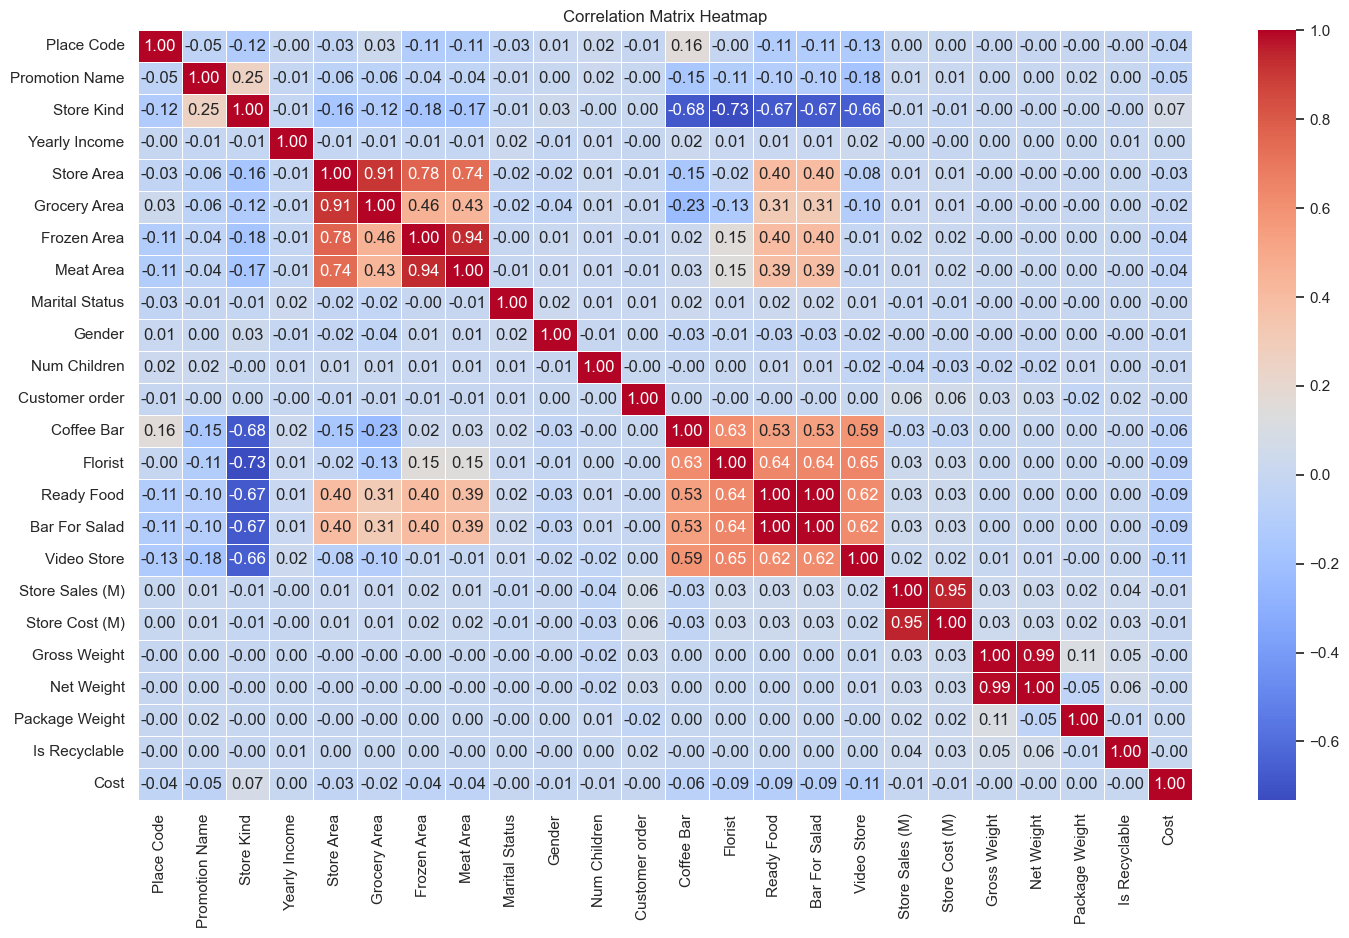

In [284]:
# Compute the correlation matrix
correlation_matrix = train.corr()

#Graph I.
plt.figure(figsize=(17, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

* Sometimes two or more variables are correlated to a independant variable which is hard to identify from correlation plot. in that case you can check the VIF (Variance Inflation Factor).

### What's the Variance Inflation Factor (VIF)?

VIF value ranges between 1 to infinity . value 1 indecation no multicollinearity and the higher value of VIF , the higher value of multicollinearity.

* VIF between `1:5` indecating moderate multicollinearity.
* VIF between `5:10` indecating higher level of multicollinearity.
* VIF between `10:..` indecating very high level multicollinearity.

In [292]:
# check about multicollenarity

from statsmodels.stats.outliers_influence import variance_inflation_factor

columns= train.drop(columns='Cost').columns
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train.drop(columns='Cost').values, i) for i in range(len(columns))]
  
vif_data

,feature,VIF
0,Place Code,5.335845
1,Promotion Name,4.964340
2,Store Kind,5.702378
3,Yearly Income,3.388297
4,Store Area,22.476841
5,Marital Status,2.001651
6,Gender,1.940639
7,Num Children,4.333634
8,Customer order,4.122918
9,Coffee Bar,5.593692


It seem Ready Food	and Bar For Salad columns have the same value in each row, so we will drop one.


In [286]:
train.drop(columns=["Bar For Salad",],inplace=True)
test.drop(columns=["Bar For Salad"],inplace=True)

In [287]:
train.drop(columns=["Net Weight", "Package Weight"],inplace=True)
test.drop(columns=["Net Weight", "Package Weight"],inplace=True)

In [291]:
train.drop(["Store Cost (M)"],axis=1,inplace=True)
test.drop(["Store Cost (M)"],axis=1,inplace=True)

In [288]:
train.drop(["Grocery Area", "Frozen Area", 'Meat Area'],axis=1,inplace=True)
test.drop(["Grocery Area", "Frozen Area", 'Meat Area'],axis=1,inplace=True)

In [289]:
train.head()

,Place Code,Promotion Name,Store Kind,Yearly Income,Store Area,Marital Status,Gender,Num Children,Customer order,Coffee Bar,Florist,Ready Food,Video Store,Store Sales (M),Store Cost (M),Gross Weight,Is Recyclable,Cost
0,6,7,0,0,2842.23,1,0,2,15,1,1,1,1,8.76,4.2924,28.1997,1,602.7575
1,14,5,4,6,2814.95,1,0,4,41,0,0,0,0,6.36,1.9716,16.5710,0,708.6650
2,7,38,4,5,2192.32,0,1,5,30,0,1,0,0,10.86,4.4526,28.6358,1,564.2647
3,13,36,4,5,1974.73,1,0,4,17,1,0,0,0,1.98,0.6732,14.2161,1,724.5119
4,8,31,0,6,2862.30,0,0,1,44,1,1,1,1,11.56,4.9708,12.6172,0,519.7574


# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'>Modeling </span></b> </div>

In [293]:
X = train.drop("Cost", axis=1)
y = train["Cost"]
Test = test.drop("Unnamed: 0", axis=1).copy()

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=45)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (33032, 16)
y_train (33032,)
X_test (5830, 16)
y_test (5830,)


In [295]:
def plot_importance(model, features, num=len(X), save=False):
    
    feature_imp = pd.DataFrame({'Value': model.estimators_[0].feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [296]:
Regressor = VotingRegressor([
    ("RandomForest", RandomForestRegressor(random_state = 42, n_estimators = 500,
                                           max_features= "auto", min_samples_split=20,
                                           max_depth=20)),
    ("ExtraTree", ExtraTreesRegressor(random_state = 42, n_estimators = 500, max_depth=30 )),
])
res = cross_val_score(Regressor, X_train , y_train , scoring = "neg_root_mean_squared_error", n_jobs = -1, verbose = True, cv = 5)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


array([-80.0789939 , -76.1051368 , -78.31484525, -78.84459705,
       -81.04184739])

In [297]:
np.mean(res), np.std(res)

(-78.87708407998288, 1.6811690579703764)

In [298]:
Regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('RandomForest',
                             RandomForestRegressor(max_depth=20,
                                                   min_samples_split=20,
                                                   n_estimators=500,
                                                   random_state=42)),
                            ('ExtraTree',
                             ExtraTreesRegressor(max_depth=30, n_estimators=500,
                                                 random_state=42))])

In [299]:
preds_Regressor = Regressor.predict(X_test)
mae_Regressor = round(mean_absolute_error(y_test, preds_Regressor), 2)
rmse_Regressor = round(np.sqrt(mean_squared_error(y_test, preds_Regressor)),2)

print(rmse_Regressor)
print(mae_Regressor)

77.18
37.57


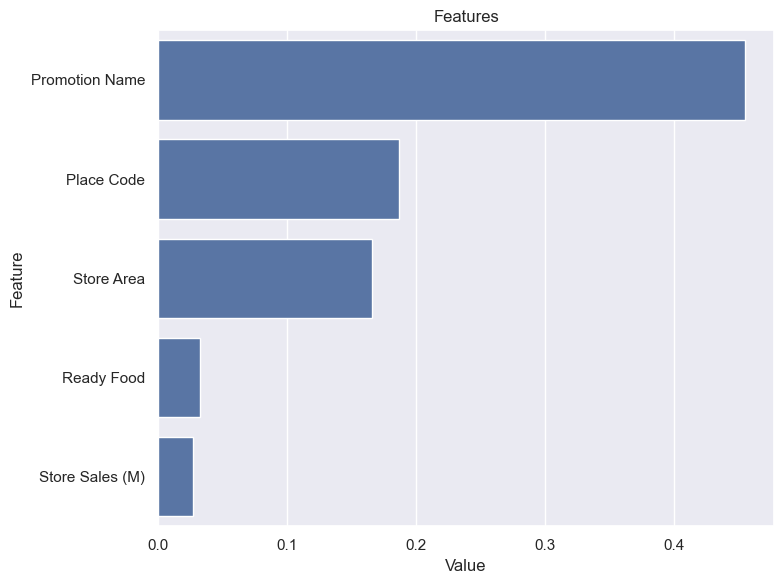

In [300]:
plot_importance(Regressor, X_train, num=5)

# <a id="1"></a>
<div style="padding: 30px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://th.bing.com/th/id/R.3be5e39321febd4c1f758691e109c8bd?rik=lkhAzU4ulIuL0Q&riu=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fcommons%2f5%2f56%2fRMS_Titanic_2.jpg&ehk=VbIvq0%2b63pXvH%2bl3Ln4tlz%2bwppwyoN%2fUTZDuGVYTHiQ%3d&risl=&pid=ImgRaw&r=0)"><b><span style='color:#404040'> Evaluation </span></b> </div>

In [301]:
predict_y = Regressor.predict(Test)

predictions = pd.DataFrame({'Id': test["Unnamed: 0"],
                           'Cost': predict_y.flatten()})

In [302]:
predictions

,Id,Cost
0,0,718.020790
1,1,617.973337
2,2,739.169759
3,3,438.633719
4,4,748.080581
...,...,...
19937,19937,359.519866
19938,19938,497.049193
19939,19939,652.505950
19940,19940,602.920736


In [303]:
predictions.to_csv('submission.csv', index=False)

### 